In [5]:
from tokenize import tokenize
from torch import nn
import torch
import math

sentences =["Hello my name is Bachir", "How are you ?"]

#lut = Embeddings(vocab_size, d_model) # look-up table (lut)


# Embedding

In [6]:
tokenized_sequences = [seq.split(' ') for seq in sentences]
tokenized_sequences

[['Hello', 'my', 'name', 'is', 'Bachir'], ['How', 'are', 'you', '?']]

The output of nn.Embedding in PyTorch is calculated through a simple lookup operation. The layer acts as a table or a dictionary, mapping integer indices to dense vectors.  
During training, these embedding vectors are adjusted through backpropagation, and the model learns to represent words in a way that captures meaningful relationships between them.

In [7]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, dimension):
        super(Embedding, self).__init__()
        self.word_embedding = nn.Embedding(vocab_size, dimension)
        
    def forward(self, x):
        return self.word_embedding(x)

## Manual preprocess

In [10]:
import nltk
from collections import Counter
#nltk.download('punkt')

from nltk.tokenize import word_tokenize
# Tokenize text
text_list = ["Hello, how are you doing today again?", "I have to go to work", " the cat is so cute"]
tokenized_test_list = [word_tokenize(text.lower()) for text in text_list]
all_tokens = [word for sentence_tokens in tokenized_test_list for word in sentence_tokens]

# Create a vocabulary
# Create a vocabulary mapping each unique word to a numerical index. 
# You can use Python's collections.Counter to count word frequencies and assign indices based on the frequency.
word_counts = Counter(all_tokens)
#sorted_words = sorted(word_counts, key=word_counts.get, reverse=True)
word_to_idx = {word: idx for idx, word in enumerate(word_counts.keys())}

# Convert Text to Indices:
# Map each word in your text to its corresponding index in the vocabulary.
text_indices = [[word_to_idx[word] for word in tokens] for tokens in tokenized_test_list]

#Use embedding
vocab_size = len(word_to_idx)
embedding_dim = 50
embedding_layer = Embedding(vocab_size, embedding_dim)

# apply to text_indices
embeddings = [embedding_layer(torch.tensor(x)) for x in text_indices]


In [11]:
for embed in embeddings:
    print(embed.size())

torch.Size([9, 50])
torch.Size([6, 50])
torch.Size([5, 50])


## Automated preprocess

In [26]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [27]:
batch_sentences = [
    "But what about second breakfast?",
    "Don't think he knows about second breakfast, Pip.",
    "What about elevensies?",
    "In a cold and gray Chicago morning, a poor little baby child is born in the ghetto",
    "I'll be there for you and the rain starts to pour",
    "I like big butts and I cannot lie",
]

encoded_input = tokenizer(batch_sentences, padding=True, return_tensors="pt")


encoded_input.input_ids.size()


torch.Size([6, 21])

In [30]:
tokenizer.vocab_size

28996

In [28]:
tokenizer.decode(encoded_input["input_ids"][3])

'[CLS] In a cold and gray Chicago morning, a poor little baby child is born in the ghetto [SEP]'

# Positional embedding

### register_buffer
In PyTorch, register_buffer is a method used in the definition of a custom neural network module (subclass of nn.Module). This method is used to register a tensor as a persistent buffer, meaning that the tensor will be part of the module's state, but it won't be considered as a model parameter.  

- Buffers registered with register_buffer are not treated as parameters that require optimization through gradient descent. They are typically used for constants or auxiliary variables that don't need gradients.

- If you assign a tensor directly to self, it won't be automatically excluded from gradient computation. You would need to manage its gradient properties manually if you don't want it to be optimized.

## Positional encoding intuition

Positional encoding is introduced to provide the model with information about the order or position of words in a sequence, as Transformers don't have an inherent sense of order.

The positional encoding is added to the input embeddings before feeding them into the Transformer model. It allows the model to differentiate between the positions of tokens in the sequence.

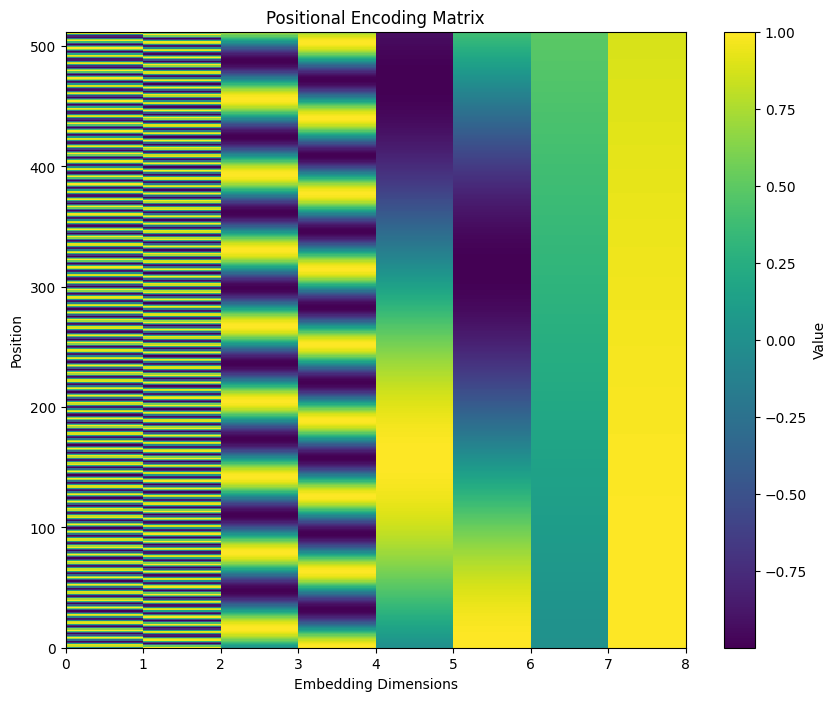

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def positional_encoding(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def get_positional_encoding(position, d_model):
    angle_rads = positional_encoding(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)

    # Apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # Apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    return angle_rads

position = 512
d_model = 8

pos_enc = get_positional_encoding(position, d_model)

plt.figure(figsize=(10, 8))
plt.pcolormesh(pos_enc, cmap='viridis')
plt.xlabel('Embedding Dimensions')
plt.ylabel('Position')
plt.colorbar(label='Value')
plt.title('Positional Encoding Matrix')
plt.show()

This is a heatmap where each row corresponds to the positional encoding for a specific position in the sequence, and each column corresponds to a dimension in the model's hidden representation.  

Interpretation

- Each row in the heatmap represents the positional encoding vector for a specific position in the sequence.
- Different positions have different encoding patterns, allowing the model to distinguish between them.
- Each dimension in the model's hidden representation contributes to capturing different aspects of the position information.

This positional encoding matrix is added to the input embeddings, providing the Transformer model with information about the position of tokens in the sequence. It helps the model capture sequential relationships in the absence of explicit order information.

In [ ]:
class PositionalEmbedding(nn.Module):
    def __init__(self, dimension, max_seq_length=2000):
        super(PositionalEmbedding, self).__init__()

        positional_encoding = torch.zeros(max_seq_length, dimension)    
        for pos in range(max_seq_length):
            for i in range(dimension):
                if i%2 == 0:
                    pe = math.sin(pos / 1000**(2*i/dimension))
                else:
                    pe = math.cos(pos / 1000**(2*i/dimension))
                positional_encoding[pos, i] = pe

        self.register_buffer('positional_encoding', positional_encoding)
        
    def forward(self, x):
        return x + self.positional_encoding[:x.size(1), :]